In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set_style("darkgrid")
import re
import datetime as dt

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
mpl.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
data = pd.read_csv("data/ufc_clean.csv")
data = data.set_index(pd.DatetimeIndex(data['Date']))
data.drop(['Date', 'Promotion'], axis=1, inplace=True)
data.head()

,Event,Main_Event,Title,Fighter_1,Fighter_2,Rematch,Venue,City,Attendance,Gate,Buyrate
Date,,,,,,,,,,,
1993-11-12,UFC 1,1,The Beginning,NaN,NaN,0,McNichols Sports Arena,"Denver, Colorado",7800.000,nan,86000.000
1994-03-11,UFC 2,1,No Way Out,NaN,NaN,0,Mammoth Gardens,"Denver, Colorado",2000.000,nan,300000.000
1994-09-09,UFC 3,1,The American Dream,NaN,NaN,0,Grady Cole Center,"Charlotte, North Carolina",3000.000,nan,90000.000
1994-12-16,UFC 4,1,Revenge of the Warriors,NaN,NaN,0,Expo Square Pavilion,"Tulsa, Oklahoma",5857.000,nan,120000.000
1995-04-07,UFC 5,1,Gracie vs. Shamrock 2,Gracie,Shamrock,1,Independence Arena,"Charlotte, North Carolina",6000.000,nan,260000.000


# Buyrate Analysis of UFC Main Events

In [4]:
ufc = data[data['Main_Event'] == 1]
ufc10 = ufc['2008':'2018']

In [5]:
# ufc 100
ufc10.at['2009-07-11', 'Title'] = 'UFC 100'

# UFC 229 PPV estimate
ufc10.at['2018-10-06', 'Buyrate'] = 2400000

# seperating the diaz bros
ufc10.at['2016-03-05', 'Fighter_2'] = 'Nick Diaz'
ufc10.at['2011-10-29', 'Fighter_2'] = 'Nick Diaz'
ufc10.at['2016-03-05', 'Fighter_2'] = 'Nate Diaz'
ufc10.at['2016-08-20', 'Fighter_1'] = 'Nate Diaz'


/home/will/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Impute missing Buyrate data

In [6]:
median_yearly_buy = ufc10.resample('Y')['Buyrate'].median()
years = median_yearly_buy.index.year
median_yearly_buy.index = years
median_yearly_buy

Date
2008   505000.000
2009   500000.000
2010   520000.000
2011   332500.000
2012   410000.000
2013   355000.000
2014   222500.000
2015   600000.000
2016   322000.000
2017   265000.000
2018   325000.000
Name: Buyrate, dtype: float64

In [7]:
null_ix = ufc10[ufc10['Buyrate'].isnull()]['Buyrate'].index

for i in null_ix:
    ufc10.at[i, 'Buyrate'] = median_yearly_buy[i.year]

### Average Buyrate

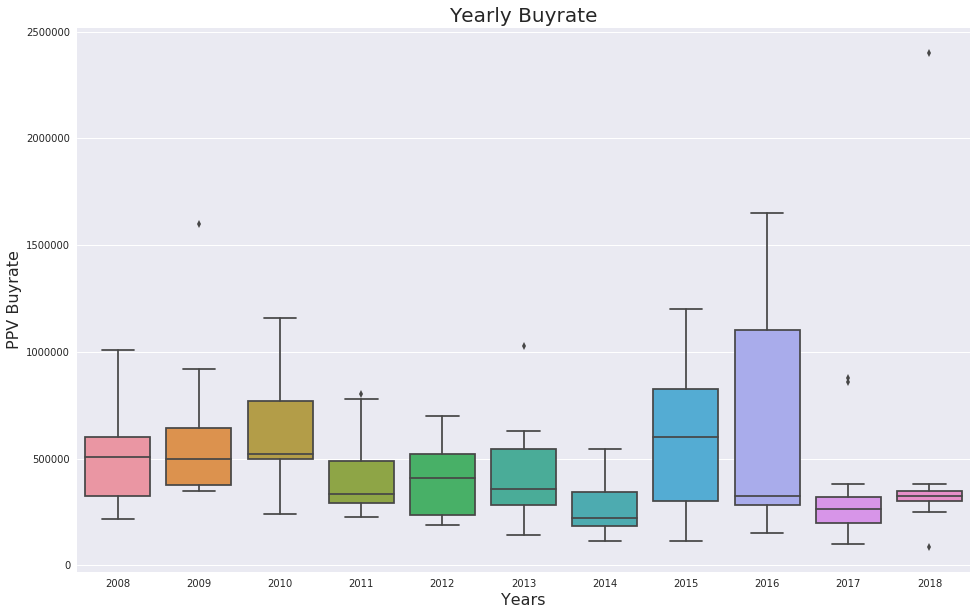

In [77]:
sns.boxplot(x= ufc10.index.year, y=ufc10['Buyrate'],)
plt.title('Yearly Buyrate', fontsize=20)
plt.ylabel('PPV Buyrate', fontsize=16)
plt.xlabel("Years", fontsize=16)

plt.savefig("images/0.png")


### Cumulative PPV Buys per Year

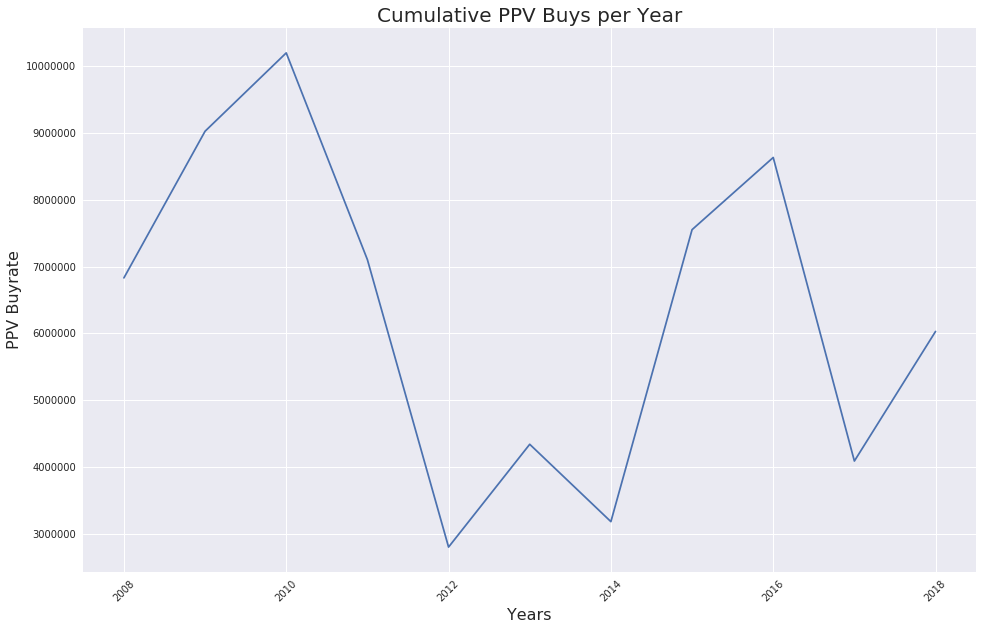

In [75]:
yearly_ppv_sum = ufc10.resample('Y')['Buyrate'].sum()
years = yearly_ppv_sum.index.year

plt.figure()
plt.plot(years, yearly_ppv_sum.values)

plt.ticklabel_format(style="plain")
#plt.xticks(years)
plt.xlabel("Years", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.title("Cumulative PPV Buys per Year", fontsize=20)
plt.savefig("images/1.png")

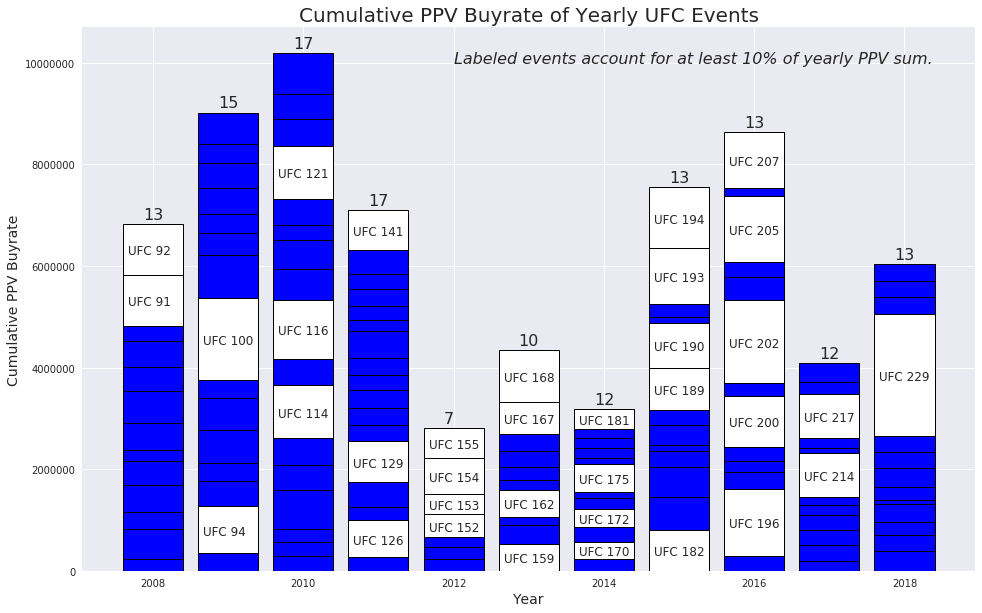

In [64]:
plt.figure()
sns.set()

plt.ticklabel_format(style='plain', axis='y')
for year in years:
    df = ufc10[str(year)]
    last = 0
    for buyrate, event in zip(df['Buyrate'], df['Event']):

        if buyrate / df['Buyrate'].sum() > 0.1:
            plt.bar(year, buyrate, color='w', bottom=last, edgecolor='k', linewidth=1)
            plt.annotate(event,
                         xy=(year, last + buyrate/2),
                         xycoords='data',
                         xytext=(-25, -5),
                         textcoords='offset points', fontsize=12)
        else:
            plt.bar(year, buyrate, color='b', bottom=last, edgecolor='k', linewidth=1)

            
        last += buyrate
    plt.annotate(str(len(df)), xy=(year, last + 100000),
                 xycoords='data',
                 xytext=(-10, 0),
                 textcoords='offset points', fontsize=16)
    


plt.title('Cumulative PPV Buyrate of Yearly UFC Events', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cumulative PPV Buyrate', fontsize=14)
plt.text(2012, 10000000, 'Labeled events account for at least 10% of yearly PPV sum.',
         fontsize=16, fontstyle='italic')
plt.savefig('images/2.png')

### Top PPV Event per Year

In [11]:
ufc10['2010'][['Event', 'Title','Buyrate']].sort_values(by='Buyrate', ascending=False).iloc[0].name

Timestamp('2010-07-03 00:00:00')

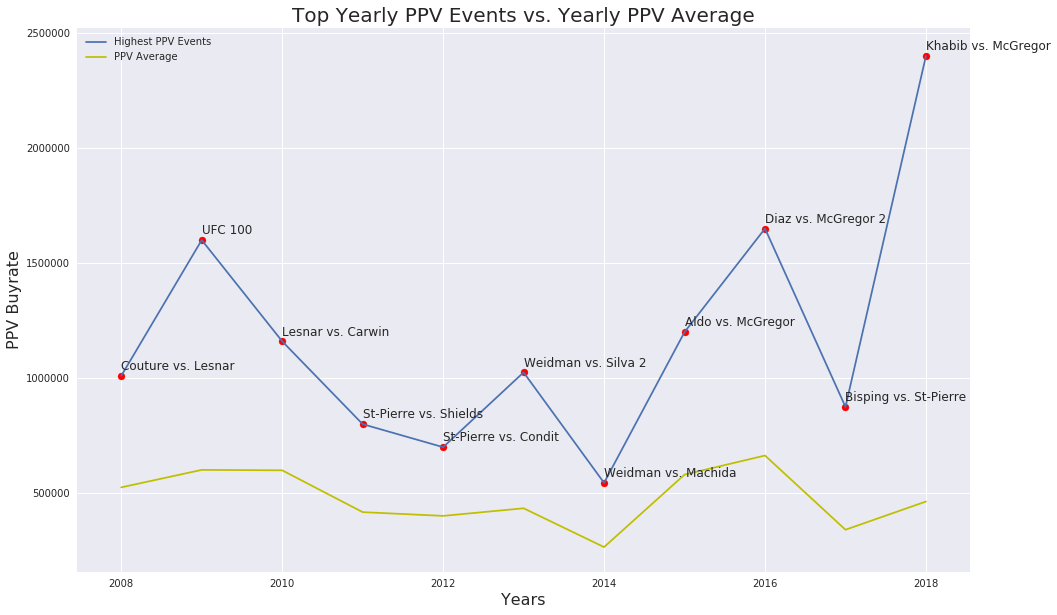

In [76]:
yearly_ppv_max = ufc10.resample('Y')['Buyrate'].max()
yearly_ppv_avg = ufc10.resample('Y')['Buyrate'].mean()

plt.figure()

plt.plot(years, yearly_ppv_max.values, label="Highest PPV Events")
plt.scatter(years, yearly_ppv_max.values, c='r')
plt.plot(years, yearly_ppv_avg.values, c='y', label="PPV Average")


for year in years:
    top_event = ufc10[str(year)][['Event', 'Title','Buyrate']].sort_values(by='Buyrate', ascending=False).iloc[0]
    plt.annotate(top_event['Title'], (year, top_event['Buyrate'] + 25000))

plt.legend()
plt.title("Top Yearly PPV Events vs. Yearly PPV Average", fontsize=20)
plt.xlabel("Years", fontsize=16)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.savefig("images/3.png")

In [13]:
rematches = ufc10.loc[ufc10['Rematch'] == 1]
yearly_rematch_ppv_avg = rematches.resample('Y')['Buyrate'].mean().values
delta = yearly_rematch_ppv_avg - yearly_ppv_avg

pos = delta.copy()
neg = delta.copy()

pos[pos <= 0] = np.nan
neg[neg > 0] = np.nan

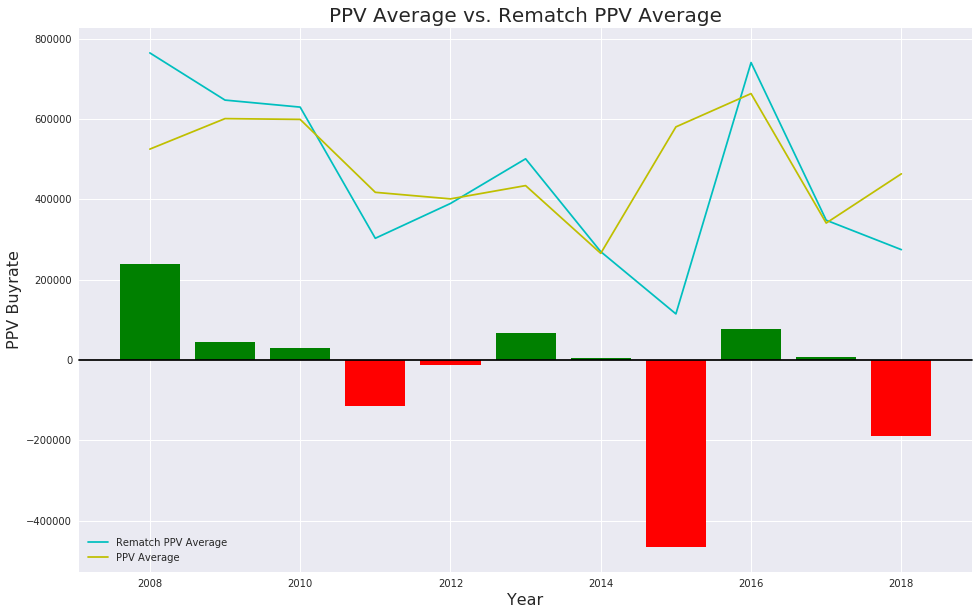

In [69]:
plt.figure()
sns.set()


plt.plot(years, yearly_rematch_ppv_avg, c='c', label="Rematch PPV Average")
plt.plot(years, yearly_ppv_avg.values, c='y', label="PPV Average")
plt.bar(years, pos, color='g')
plt.bar(years, neg, color='r')
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Rematch Average relative to Yearly Average")

plt.legend()

plt.title("PPV Average vs. Rematch PPV Average", fontsize=20)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("images/4.png")

In [15]:
# rematches = ufc10.loc[ufc10['Rematch'] == 1]
# yearly_rematch_ppv_avg = rematches.resample('Y')['Buyrate'].mean()

# plt.figure(figsize=(16, 10))

# plt.plot(years, yearly_rematch_ppv_avg.values, label="Rematch PPV Average")
# plt.plot(years, yearly_ppv_avg.values, c='g', label="PPV Average")

# plt.xlabel("Years")
# plt.xticks(rotation=45)
# plt.ylabel("PPV Buyrate")

# plt.legend()
# plt.title("PPV Average vs. Rematch PPV Average")
# plt.savefig("images/3.png")

In [16]:
round(yearly_rematch_ppv_avg / yearly_ppv_avg - 1, 2)

Date
2008-12-31    0.460
2009-12-31    0.080
2010-12-31    0.050
2011-12-31   -0.270
2012-12-31   -0.030
2013-12-31    0.150
2014-12-31    0.020
2015-12-31   -0.800
2016-12-31    0.120
2017-12-31    0.020
2018-12-31   -0.410
Freq: A-DEC, Name: Buyrate, dtype: float64

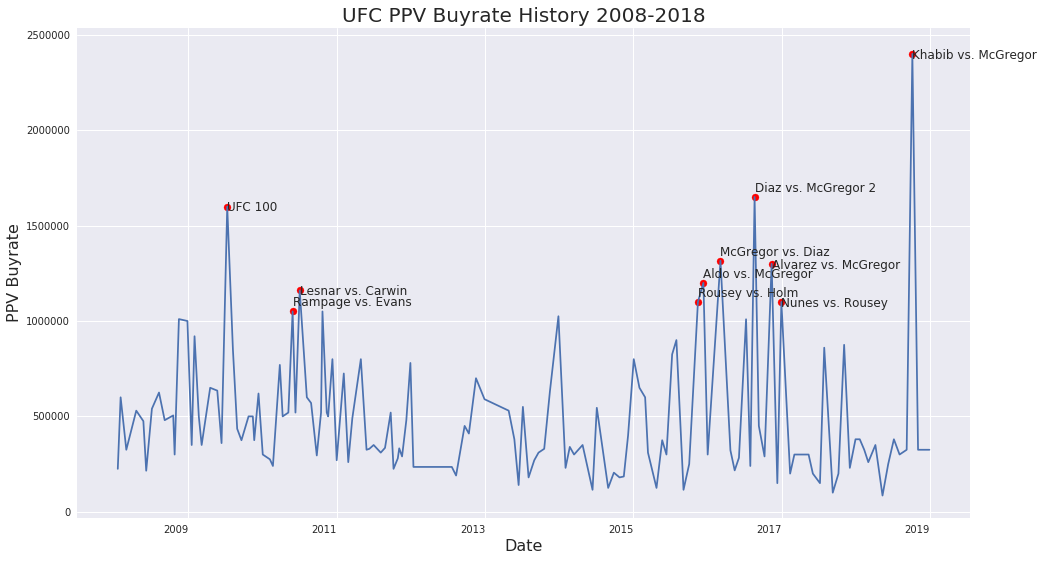

In [68]:
plt.figure()
ufc10['Buyrate'].plot()
top10_fights = ufc10.sort_values('Buyrate', ascending=False)[:10]
plt.scatter(top10_fights.index, top10_fights['Buyrate'], c='r')

offset_ix = 1
offset_base = 26000
for i in top10_fights.index:
    offset_ix += 1
    if offset_ix % 2 == 0:
        offset = -(offset_base)
    else: offset = offset_base
    plt.annotate(ufc10.at[i, 'Title'], (i, ufc10.at[i, 'Buyrate'] + offset))

plt.title('UFC PPV Buyrate History 2008-2018', fontsize=20)
plt.ylabel("PPV Buyrate", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=0)

plt.savefig("images/5.png")

In [18]:
fighter1 = ufc10.copy()
fighter1.insert(0, "Fighter", fighter1["Fighter_1"])

fighter2 = ufc10.copy()
fighter2.insert(0, "Fighter", fighter2["Fighter_2"])

fighters_df = pd.concat([fighter1, fighter2], sort=False)
headline_fights = fighters_df['Fighter'].value_counts()
headline_rematches = fighters_df.groupby('Fighter')['Rematch'].sum().sort_values(ascending=False)
# cum_ppv = fighters_df.groupby('Fighter')['Buyrate'].sum().sort_values(ascending=False)

fighters = fighters_df.pivot_table(values=['Attendance', 'Buyrate', 'Gate'], index='Fighter')
fighters['Headline Fights'] = headline_fights
fighters['Headline Rematches'] = headline_rematches
# fighters['Cumulative PPV Buys'] = cum_ppv


In [19]:
fighters

,Attendance,Buyrate,Gate,Headline Fights,Headline Rematches
Fighter,,,,,
Akiyama,17133.000,520000.000,2560000.000,1,0
Aldo,14234.667,370833.333,6003124.500,6,2
Alvarez,20427.000,1300000.000,17700000.000,1,0
Bagautinov,13506.000,115000.000,nan,1,0
Barão,13811.000,226666.667,4100000.000,3,1
Belfort,15040.333,516666.667,2640333.333,3,0
Bigfoot,12380.000,380000.000,nan,1,1
Bisping,15287.200,494600.000,3222168.750,5,2
Bonnar,16844.000,410000.000,nan,1,0


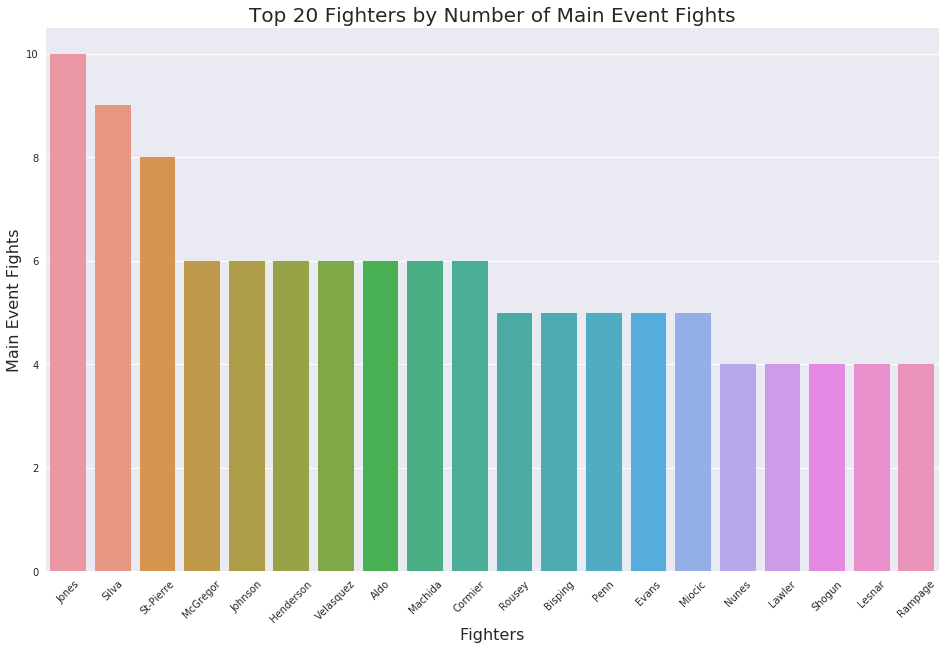

In [70]:
plt.figure()
sns.barplot(headline_fights[:20].index, headline_fights[:20])
plt.xticks(rotation=45)
plt.title("Top 20 Fighters by Number of Main Event Fights", fontsize=20)
plt.ylabel("Main Event Fights", fontsize=16)
plt.xlabel("Fighters", fontsize=16)

plt.savefig("images/6.png")

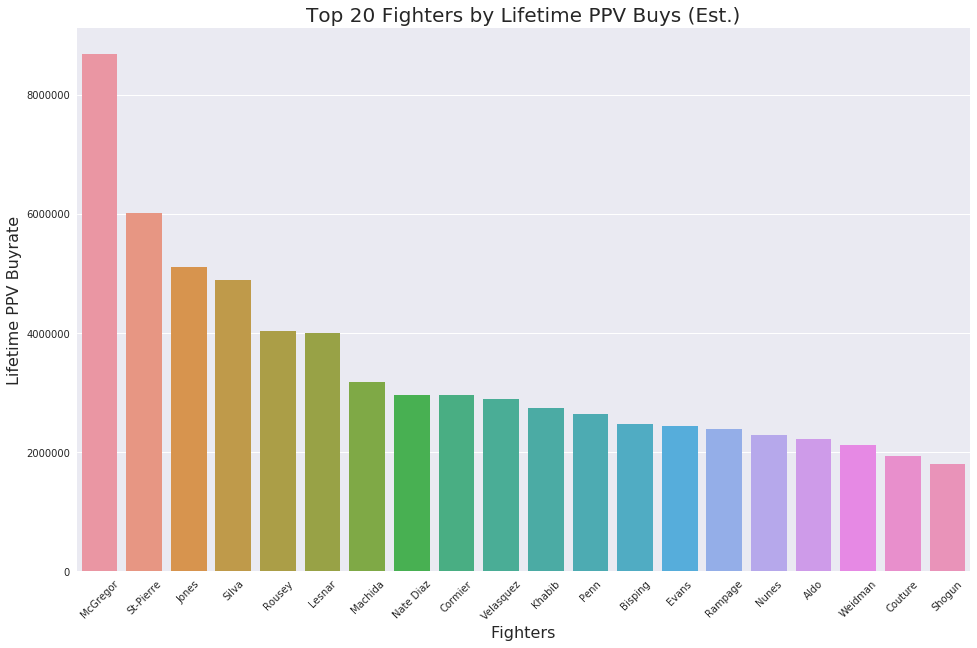

In [71]:
ppv_estimate = (fighters['Buyrate'] * fighters['Headline Fights']).sort_values(ascending=False)

#fig = plt.figure()
sns.barplot(ppv_estimate[:20].index, ppv_estimate[:20])
plt.ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Fighters by Lifetime PPV Buys (Est.)", fontsize=20)
plt.ylabel("Lifetime PPV Buyrate", fontsize=16)
plt.xlabel("Fighters", fontsize=16)
plt.xticks(rotation=45)

plt.savefig("images/7.png")

In [22]:
mcgregor = fighters_df.loc[fighters_df['Fighter'] == 'McGregor'].sort_index()

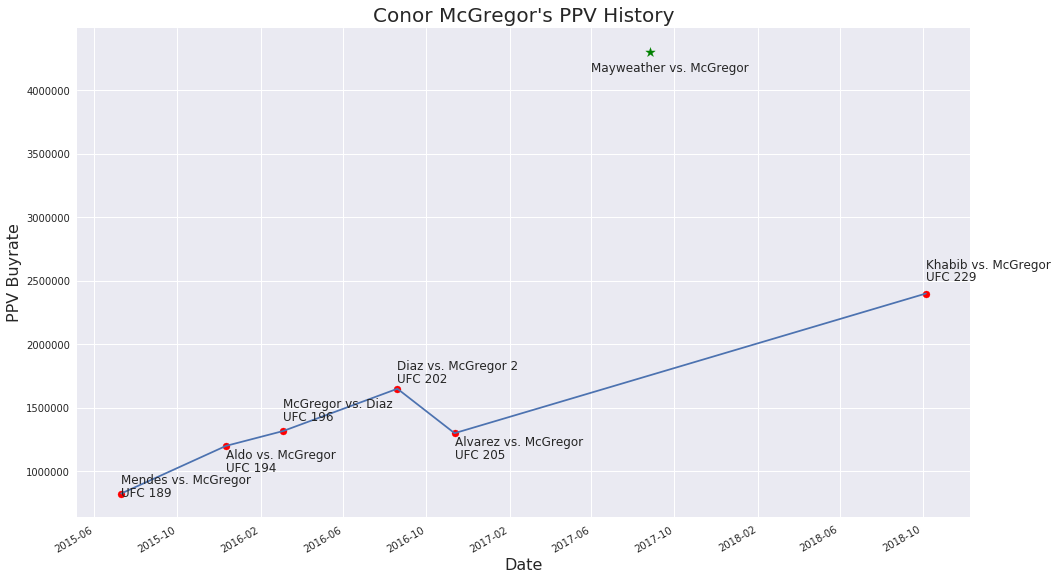

In [72]:
plt.figure()


mcgregor['Buyrate'].plot()
plt.scatter(mcgregor.index, mcgregor['Buyrate'], c='r')

plt.scatter('2017-08-26', 4300000, c='g', marker='*', s=100)
plt.annotate('Mayweather vs. McGregor', ('2017-06-01', 4150000))

y_vals = [900000, 1100000, 1500000, 1800000, 1200000, 2600000]
for i, y in zip(mcgregor.index, y_vals):
    plt.annotate(mcgregor.at[i, 'Title'], (i, y))
    plt.annotate(mcgregor.at[i, 'Event'], (i, y - 100000))

plt.ylabel('PPV Buyrate', fontsize=16)
plt.title("Conor McGregor's PPV History", fontsize=20)
plt.xlabel("Date", fontsize=16)

plt.savefig("images/8.png")

### Percentiles

In [24]:
sorted_buyrates = ufc10['Buyrate'].sort_values()

np.percentile(sorted_buyrates, 50)

367500.0

In [25]:
perc_95 = ufc10.loc[ufc10.Buyrate >= np.percentile(sorted_buyrates, 95)]

import pprint as pp

pp.pprint([x for x in zip(perc_95['Title'], perc_95['Buyrate'])])

[('UFC 100', 1600000.0),
 ('Lesnar vs. Carwin', 1160000.0),
 ('Rousey vs. Holm', 1100000.0),
 ('Aldo vs. McGregor', 1200000.0),
 ('McGregor vs. Diaz', 1317000.0),
 ('Diaz vs. McGregor 2', 1650000.0),
 ('Alvarez vs. McGregor', 1300000.0),
 ('Nunes vs. Rousey', 1100000.0),
 ('Khabib vs. McGregor', 2400000.0)]
